## Lab 3

### Part 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.92 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и/или числа слоев и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time

In [6]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

augment = transforms.Compose([
    transforms.RandomAffine(30, [0.2, 0.2], (0.7, 1.3)),
    transforms.ToTensor(),
])

fashion_mnist_train = FashionMNIST('data', download=True, train=True, transform=augment)
fashion_mnist_test = FashionMNIST('data', download=True, train=False, transform=transforms.ToTensor())

In [7]:
class OneDim(nn.Module):
  
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [8]:
def save(what, filename):
    with open(filename, "w") as f:
        f.write(what)

In [9]:
from datetime import datetime as dt
today = dt.now().strftime("%d-%m-%Y")

In [12]:
def train(model, num_epochs, train_batch_gen, test_batch_gen, lr, label=""):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    test_acc = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True)
        for (X_batch, y_batch) in train_batch_gen:
            X_batch, y_batch = Variable(torch.FloatTensor(X_batch)).cpu(), Variable(torch.LongTensor(y_batch)).cpu()
            loss = F.cross_entropy(model.cpu()(X_batch), y_batch)
            loss.backward()
            opt.step()

            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())

        model.train(False)
        for X_batch, y_batch in test_batch_gen:
            logits = model(Variable(torch.FloatTensor(X_batch).cpu()))
            test_acc.append(np.mean((y_batch.cpu() == logits.max(1)[1].data.cpu()).numpy()))

        av_test_acc = np.mean(test_acc[-len(test_batch_gen)::])
        av_train_loss = np.mean(train_loss[-len(train_batch_gen):])

        print(f"Epoch {epoch + 1}/{num_epochs} - {time.time() - start_time:.1f}s  training loss: {av_train_loss} test accuracy: {av_test_acc:.3f}")
        
        torch.save(model.state_dict(), f"{today}_model_{label}_epoch_{epoch + 1}_test_acc_{av_test_acc}_loss_{av_train_loss:.6f}")
        save(train_loss, f"{today}_training_loss_epoch_{epoch}")
        save(test_acc, f"{today}_test_acc_epoch_{epoch}")
        
        return train_loss, test_acc

In [13]:
init_conv = 64
init_dense = 512

model = nn.Sequential(
    
    nn.Conv2d(1, init_conv, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(init_conv),
    
    nn.Conv2d(init_conv, init_conv, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(init_conv),
    nn.MaxPool2d(2),
    
    nn.Conv2d(init_conv, init_conv * 2, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(init_conv * 2),
    
    nn.Conv2d(init_conv * 2, init_conv * 2, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(init_conv * 2),
    nn.MaxPool2d(2),
    
    nn.Conv2d(init_conv * 2, init_conv * 4, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(init_conv * 4),
    
    nn.Conv2d(init_conv * 4, init_conv * 4, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(init_conv * 4),
    
    OneDim(),
    nn.Linear(7 * 7 * init_conv * 4, init_dense),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense, init_dense),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense, init_dense),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense, 10),
)

In [14]:
batch_size = 128
train_batch_gen = torch.utils.data.DataLoader(fashion_mnist_train, 
                                              batch_size=batch_size,
                                              shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(fashion_mnist_test, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [ ]:
train_loss, test_acc = train(model=model, 
                             num_epochs=15, 
                             train_batch_gen=train_batch_gen, 
                             test_batch_gen=test_batch_gen,
                             lr=0.001, 
                             label="")

### Overfitting

In [23]:
fashion_mnist_train = FashionMNIST('data', download=True, train=True, transform=test)
fashion_mnist_test = FashionMNIST('data', download=True, train=False, transform=test)

batch_size = 128
train_batch_gen = torch.utils.data.DataLoader(fashion_mnist_train, 
                                              batch_size=batch_size,
                                              shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(fashion_mnist_test, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [24]:
init_conv = 256
init_dense = 4096 * 2

over_model = nn.Sequential(
    
    nn.Conv2d(1, init_conv, 7, padding=2),
    
    nn.ReLU(),
#     nn.BatchNorm2d(init_conv),
    nn.MaxPool2d(4),
    
    to_1d(),
    nn.Linear(6 * 6 * init_conv, init_dense),
#     nn.Dropout(p=0.1),
    nn.ReLU(),
#     nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense, init_dense // 2),
#     nn.Dropout(p=0.1),
    nn.ReLU(),
#     nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense // 2, init_dense // 4),
    nn.ReLU(),
#     nn.Dropout(p=0.2),
#     nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense // 4, 10),
)

In [ ]:
over_train_loss, over_test_acc = train(model=over_model, 
                                       num_epochs=30, 
                                       train_batch_gen=train_batch_gen, 
                                       test_batch_gen=test_batch_gen,
                                       lr=0.003, 
                                       label="over")

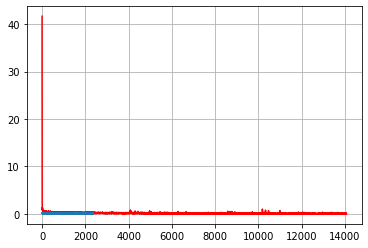

In [27]:
import matplotlib.pyplot as plt

plt.plot(over_train_loss[3:], c='r')
plt.plot(1-np.array(over_test_acc[3:]))
plt.grid()

### Fixing

In [35]:
init_conv = 256
init_dense = 4096 * 2

fixed_model = nn.Sequential(
    
    nn.Conv2d(1, init_conv, 7, padding=2),
    
    nn.ReLU(),
    nn.BatchNorm2d(init_conv),
    nn.MaxPool2d(4),
    
    to_1d(),
    nn.Linear(6 * 6 * init_conv, init_dense),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm1d(init_dense),
    
    nn.Linear(init_dense, init_dense // 2),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm1d(init_dense // 2),
    
    nn.Linear(init_dense // 2, init_dense // 4),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.BatchNorm1d(init_dense // 4),
    
    nn.Linear(init_dense // 4, 10),
)

In [ ]:
fixed_train_loss, fixed_test_acc = train(model=fixed_model, 
                                         num_epochs=30,
                                         train_batch_gen=train_batch_gen,
                                         test_batch_gen=test_batch_gen,
                                         lr=0.003,
                                         label="fixed")

In [1]:
plt.figure(figsize=(8 * 2, 4 * 3))
plt.subplot(221)
plt.title('Overfitted train loss')
plt.plot(over_train_loss[50:])
plt.subplot(222)
plt.title('Fixed train loss')
plt.plot(fixed_train_loss[50:])
plt.subplot(223)
plt.title('Overfitted test accuracy')
plt.plot(over_test_acc[50:])
plt.subplot(224)
plt.title('Fixed test accuracy')
plt.plot(fixed_test_acc[50:])
plt.show()

NameError: name 'plt' is not defined

Эффект переобучения заметен не очень сильно. Добавление dropout и batchnorm слоёв позволило получить более стабильную картину обучения и более стабильные результаты